# Pandas

In [2]:
import pandas as pd

In [3]:
users_cols = "user id | age | gender | occupation | zip code".replace(" ", "_").split("_|_")
users = pd.read_csv('http://files.grouplens.org/datasets/movielens/ml-100k/u.user', names=users_cols, sep="|")

In [68]:
ratings_cols = "user id | movie id | rating | timestamp".replace(" ", "_").split("_|_")
ratings = pd.read_csv('http://files.grouplens.org/datasets/movielens/ml-100k/u.data', names=ratings_cols, sep="\t")

In [69]:
movies_cols = "movie id | movie title | release date | video release date | IMDb URL".replace(" ", "_").split("_|_")
movies = pd.read_csv('http://files.grouplens.org/datasets/movielens/ml-100k/u.item', names=movies_cols, sep="|", usecols=range(5))

In [70]:
# quiz item
male_and_forty = users[(users['age']==40) & (users['gender']=='M')]

In [71]:
# quiz item
mean_of_female = users[(users['gender']=='F') & (users['occupation']=='programmer')].mean()

In [73]:
# messing with groupby. note different columns in the code, need to practice
# groupby by itself returns an object: users.groupby('age')
# to be useful, *apply* a function
avg_age_per_gender = users['age'].groupby(users['gender']).mean()
num_users_per_gender = users['gender'].groupby(users['gender']).count()

In [124]:
# quiz item
avg_rating_per_movie = ratings['rating'].groupby(ratings['movie_id']).mean()
max_avg_rating = avg_rating_per_movie.max()
highest_movie_ids = avg_rating_per_movie[avg_rating_per_movie==max_avg_rating]

# this was a bonus - needed isin()!
movie_ids_as_a_set = highest_movie_ids.index
highest_rated_movies = movies[movies['movie_id'].isin(movie_ids_as_set)]
highest_rated_movie_titles = highest_rated_movies['movie_title']

# rating of 5.0 is weird for these, so we should check the total frequency 
count_of_all_ratings = ratings['rating'].groupby(ratings['movie_id']).count()
count_of_highest_ratings = count_of_ratings[avg_rating_per_movie==max_avg_rating]

In [179]:
# quiz item
avg_rating = ratings['rating'].groupby(ratings['user_id']).mean()

# quiz item
grouped_data = users['gender'].groupby(users['occupation'])
is_male_dominated = grouped_data.apply(lambda i: sum(i=='M')>sum(i=='F'))

 # Scraping

In [199]:
import re
import bs4
import pickle
import urllib2
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

In [160]:
url = 'https://www.crummy.com/software/BeautifulSoup/'
contents = urllib2.urlopen(url).read()

soup = bs4.BeautifulSoup(contents, 'html5lib')
first_a = soup.find('a')
first_a.get('href') # u'bs4/download/'

link_list = [l.get('href') for l in soup.findAll('a')]

# external_links = []
# for l in link_list:
#   if l is not None and l[:4] == 'http':
#     external_links.append(l)

external_links = [l for l in link_list if l is not None and l.startswith('http')]
header = soup.find('body').find('h3')
list_hall_of_fame = [i.get_text() for i in soup.findAll('ul')]

# another way
tmp = []
for li in soup.find('ul').contents[1:]:
    tmp.append(li.get_text())
    
test =  ["".join(str(a) for a in sublist) for sublist in tmp]
# print '\n'.join(test)

In [101]:
url = 'http://www.indeed.com/jobs?q=data+analyst&l=remote'
contents = urllib2.urlopen(url).read()

# make the soup
soup = bs4.BeautifulSoup(contents, 'html5lib')

In [121]:
# here I composed from left to right. found the searchcount,
# grabbed the contents. could have also used .contents[0]
# "Jobs 1 to 10 of 85,284"

result_count = soup.find(id = 'searchCount').get_text().split(' ')[-1]
number_of_result_pages = int(np.ceil(float(result_count)/10.0))

print("Found {} total jobs on {} pages".format(result_count, number_of_result_pages))

Found 129 total jobs on 13 pages


In [144]:
base_url = 'http://www.indeed.com/'
job_links = []

for page in range(number_of_result_pages + 1):
    # url param for page number counts in increments of 10
    url = 'http://www.indeed.com/jobs?q=data+analyst&l=remote&start=' + str(page*10)
    
    html_page = urllib2.urlopen(url).read()
    soup = bs4.BeautifulSoup(html_page)
    
    link_area = soup.find(id = 'resultsCol')
    listings = link_area.findAll('div')
    listings = [i for i in listings if not i.get('class') is None and ''.join(i.get('class')) == 'rowresult']
    ids = [i.get('data-jk') for i in listings]

    for id in ids:
        job_links.append(base_url + '/rc/clk?jk=' + id)

# pickle it, so we don't have to query each time
with open('jobs.pickle', 'wb') as f:
    pickle.dump(job_links, f)
        
with open('jobs.pickle', 'r') as f:
    job_links = pickle.load(f)

In [191]:
skill_set = {'excel': 0, 'degree': 0}

with open('scraped_links_restart.pickle', 'wb') as f:
    pickle.dump((skill_set, 0), f)
    
with open('scraped_links_restart.pickle', 'r') as f:
    # load returns a tuple so the second value needs to be assigned
    skill_set, index = pickle.load(f)
    print('{} websites to go'.format(len(job_links) - index))
    
# note to self: still not exactly sure where index comes from; nothing in docs

127 websites to go


In [192]:
counter = 0

for link in job_links:
    counter += 1
    
    try: 
        html_page = urllib2.urlopen(link).read()
    except urllib2.HTTPError:
        print("Httperror")
        continue
    except urllib2.URLError:
        print("Urlerror")
        continue
    except ValueError:
        print("ValueError")
        continue
    except socket.error as error:
        print("Connection closed, socket error")
        continue
    
    # get words only + python3
    html_text = re.sub('[^a-z.+3]',' ', html_page.lower())

    for key in skill_set.keys():
        if key in html_text:
            skill_set[key] += 1

print(skill_set)

{'excel': 59, 'degree': 80}


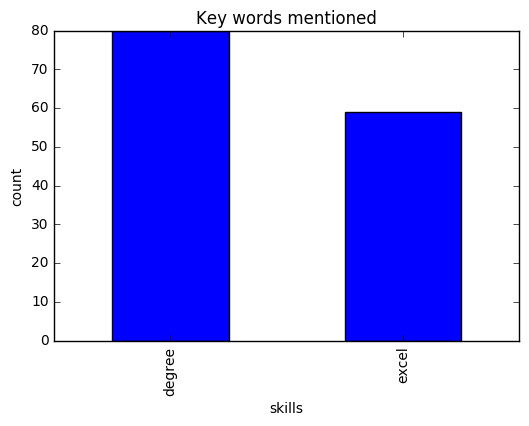

In [202]:
pseries = pd.Series(skill_set)
pseries.plot(kind = 'bar')
plt.title('Key words mentioned')
plt.xlabel('skills')
plt.ylabel('count')

# Poke API

In [206]:
import json
import requests

In [225]:
base_url = 'http://pokeapi.co/api/v2/'
query = 'type/water'
results = requests.get(base_url + query)

with open('pokemon.pickle', 'wb') as f:
    pickle.dump(results.json(), f)

In [243]:
with open('pokemon.pickle', 'r') as f:
    poke_response = pickle.load(f)

In [305]:
water_poke_names = [poke['pokemon']['name'] for poke in poke_response['pokemon']]
water_poke_urls = [poke['pokemon']['url'] for poke in poke_response['pokemon']]

In [327]:
df = pd.DataFrame(data=[water_poke_names, water_poke_urls]).transpose()
df.columns=['name', 'link']
# could set name as index: df.set_index(['name'])

In [378]:
df.head(3)

,name,link,length
0,squirtle,http://pokeapi.co/api/v2/pokemon/7/,long
1,wartortle,http://pokeapi.co/api/v2/pokemon/8/,short
2,blastoise,http://pokeapi.co/api/v2/pokemon/9/,short


In [ ]:
length = df['name'].apply(lambda i: 'short' if len(i) > 8 else 'long')
df['length'] = length
df[df['length']=='long'].count()/128
df[df['length']=='short'].count()/128

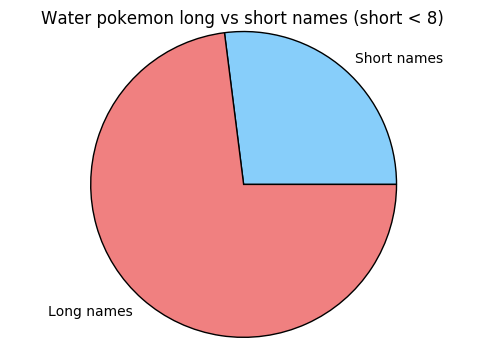

In [410]:
labels = 'Short names', 'Long names'
colors = ['lightskyblue', 'lightcoral']
sizes = [27, 73]

plt.pie(sizes, colors=colors, labels=labels)
plt.axis('equal')
plt.title('Water pokemon long vs short names (short < 8)')